In [1]:
# !nvidia-smi
# !pip install prefetch_generator
# !pip install timm
# !pip install albumentations

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import trange
import torchvision
import boto3
import io
import sagemaker
from sagemaker import get_execution_role
import tempfile
import PIL
import time
from datetime import timedelta
from prefetch_generator import BackgroundGenerator
import timm
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn import model_selection, metrics

In [3]:
# Make sure you're using cuda (GPU) by checking the hardware accelerator under Runtime -> Change runtime type
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using:", device)

We're using: cuda


# Download dataset from AWS S3

In [4]:
dataset_name = "Dataset"
if not os.path.exists(dataset_name):
    !pip install cloudpathlib[s3,gs,azure]
    from cloudpathlib import CloudPath
    cp = CloudPath("s3://cassavaproject")
    cp.download_to("./" + dataset_name)
else:
    print(f"File exists: {dataset_name}")

File exists: Dataset


# Preprocessing

In [5]:
class MyDataset(Dataset):

    def __init__(self, df, transform=None):
        self.image_path = 'Dataset/train_images'
        self.labels = df
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = self.image_path + '/' + self.labels.iloc[idx]['image_id']

        # Read the image from the file path
        #image = Image.open(img_name)
        image = cv2.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = torchvision.io.read_file(img_name)
        #image = torchvision.io.decode_jpeg(image, device="cpu")
        #image = image.float().
        
        # Transform the image using self.transform
        if self.transform:
            image = self.transform(image=image)["image"]

        if "label" in self.labels.columns:
            label = self.labels.iloc[idx]['label']
            sample = (image, label)
        else:
            sample = (image)
        return sample

In [6]:
#Used for directly download and read file from AWS S3.
#If running the download cell above, use 'MyDataset' class instead of this one.
class MyDatasetS3(Dataset):

    def __init__(self, df, transform=None):
        #File path for csv and images
        self.image_path = 'train_images'
        
        #Connect to s3 file
        self.csv_path = df
        self.s3_client = boto3.resource('s3')
        self.bucket = self.s3_client.Bucket('cassavaproject')
        
        s3 = boto3.client('s3')
        obj = s3.get_object(Bucket = 'cassavaproject',Key = 'train.csv')

        self.labels = pd.read_csv(obj['Body'])
        
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        img_name = self.image_path + '/' + self.labels.iloc[idx]['image_id']
        
        # we can download the file from S3 to a temporary file locally, then store that opened file as our image variable.
        # we need to create the local file name
        obj = self.bucket.Object(img_name)
        tmp = tempfile.NamedTemporaryFile()
        tmp_name = '{}.jpg'.format(tmp.name)

        # now we can actually download from S3 to a local place
        with open(tmp_name, 'wb') as f:
            obj.download_fileobj(f)
            f.flush()
            f.close()
            
            image = torchvision.io.read_file(tmp_name)
            image = torchvision.io.decode_jpeg(image, device="cpu")
            image = image.float()
            
        # Transform the image using self.transform
        if self.transform:
            image = self.transform(image=image)["image"]

        if "label" in self.labels.columns:
            label = self.labels.iloc[idx]['label']
            sample = (image, label)
        else:
            sample = (image)
        return sample

In [7]:
# Credit: https://www.kaggle.com/code/aliabdin1/calculate-mean-std-of-images/notebook
mean = np.array([0.42984136, 0.49624753, 0.3129598])
std = np.array([0.21417203, 0.21910103, 0.19542212])

In [8]:
train_transform = torch.nn.Sequential(transforms.Resize((256,256),antialias=True), 
                                      transforms.Normalize(mean=mean,std=std))

In [9]:
albu_transform_train = A.Compose(
        [A.CenterCrop(height=256, width=256), 
         A.HorizontalFlip(p=0.5),
         A.VerticalFlip(p=0.5),
         A.RandomRotate90(p=0.5),
         A.RandomBrightnessContrast(p=0.85), 
         A.CoarseDropout(p=0.5),
         A.Normalize(mean=mean, std=std),
         ToTensorV2()
        ])

In [10]:
albu_transform_test = A.Compose(
        [A.CenterCrop(height=256, width=256),
         A.Normalize(mean=mean, std=std),
         ToTensorV2()
        ])

In [11]:
df = pd.read_csv('Dataset/train.csv')

train_df, test_df = model_selection.train_test_split(
    df, test_size=0.3, random_state=42, stratify=df.label.values
)

train_data = MyDataset(train_df, transform = albu_transform_train)
test_data = MyDataset(test_df, transform = albu_transform_test)

# Define our model

In [12]:
timm.list_models('*vgg*')

['repvgg_a2',
 'repvgg_b0',
 'repvgg_b1',
 'repvgg_b1g4',
 'repvgg_b2',
 'repvgg_b2g4',
 'repvgg_b3',
 'repvgg_b3g4',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn']

In [13]:
test_model = timm.create_model('vgg19', pretrained=True)
test_model.default_cfg

{'url': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
 'num_classes': 1000,
 'input_size': (3, 224, 224),
 'pool_size': (7, 7),
 'crop_pct': 0.875,
 'interpolation': 'bilinear',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'first_conv': 'features.0',
 'classifier': 'head.fc',
 'architecture': 'vgg19'}

In [14]:
class OurModel(nn.Module):
    def __init__(self, num_classes):
        super(OurModel, self).__init__()
        self.model = timm.create_model('vgg19', pretrained=True) #torchvision.models.resnet34(weights='IMAGENET1K_V1')
        self.drop = nn.Dropout(p=0.2)
        self.fc = nn.Linear(in_features=self.model.num_classes, out_features=num_classes)
        self.softmax = nn.Softmax()
    def forward(self, input):
        out = self.model(input)
        out = self.drop(out)
        out = self.fc(out)
        softmax = self.softmax(out)
        return softmax

# Train our model

In [15]:
model = OurModel(5).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=5e-6, weight_decay=2e-6, 
                             amsgrad=False) #torch.optim.Adam(model.parameters(), lr=5*1e-3)

In [16]:
class DataLoaderX(DataLoader):

    def __iter__(self):
        return BackgroundGenerator(super().__iter__())

In [17]:
train_loader = DataLoaderX(dataset=train_data, batch_size = 128, shuffle= True, num_workers=2, pin_memory=True)
test_loader = DataLoaderX(dataset=test_data, batch_size = 128, shuffle=False, num_workers=2, pin_memory=True)

In [18]:
print('Start fine-tuning...')

Start fine-tuning...


In [19]:
def test_model(model, test_loader):
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = model(images)

            _,prediction = torch.max(outputs.data, 1)
            correct += (prediction == labels).sum().item()
            total += labels.size(0)
        model.train()
        return 100 * correct / total

In [20]:
def get_run_time(start_time):
    end_time = time.time()
    runtime = end_time - start_time
    return runtime

In [21]:
best_acc = 0.
best_epoch = None
end_patient = 0
num_epochs = 50
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

save_model_path = ''
train_loss = []
train_accuracy = []
test_accuracy = []

start_time = time.time()


for epoch in trange(num_epochs):
    correct = 0
    total = 0
    epoch_loss = 0.
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss
        _, prediction = torch.max(outputs.data, 1)
        correct += (prediction == labels).sum().item()
        total += labels.size(0)

        time_diff = get_run_time(start_time)

        # print('Epoch [{}/{}]: Iter {}, Loss {:.4f}, Runtime {:.0f}m {:.0f}s'.format(epoch + 1, num_epochs, i + 1, loss, time_diff//60, time_diff%60))
        train_loss.append(loss)

    train_acc = 100 * correct / total
    print('Testing on test dataset...')
    test_acc = test_model(model, test_loader)
    print('Epoch [{}/{}] Loss: {:.4f} Train_Acc: {:.4f}  Test_Acc: {:.4f}'
          .format(epoch + 1, num_epochs, epoch_loss, train_acc, test_acc))
    scheduler.step(test_acc)
    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)
    if (test_acc > best_acc) & (test_acc > 84.5):
        best_acc = test_acc
        best_epoch = epoch + 1
        print('The accuracy is improved, save model')
        torch.save(model.state_dict(), os.path.join(
                                                    'vgg19_acc_%g.pth' %(best_acc)))

print('After the training, the end of the epoch %d, the accuracy %g is the highest' % (best_epoch, best_acc))

  0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_8106/233460404.py:12: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax = self.softmax(out)


Testing on test dataset...


  2%|▏         | 1/50 [02:38<2:09:29, 158.56s/it]

Epoch [1/50] Loss: 151.5809 Train_Acc: 62.3823  Test_Acc: 67.9283
Testing on test dataset...


  4%|▍         | 2/50 [05:15<2:06:00, 157.51s/it]

Epoch [2/50] Loss: 141.3388 Train_Acc: 70.1008  Test_Acc: 72.0405
Testing on test dataset...


  6%|▌         | 3/50 [07:52<2:03:10, 157.24s/it]

Epoch [3/50] Loss: 137.7943 Train_Acc: 73.3658  Test_Acc: 73.4268
Testing on test dataset...


  8%|▊         | 4/50 [10:29<2:00:29, 157.17s/it]

Epoch [4/50] Loss: 140.6348 Train_Acc: 70.7485  Test_Acc: 73.9720
Testing on test dataset...


 10%|█         | 5/50 [13:06<1:57:49, 157.10s/it]

Epoch [5/50] Loss: 135.2889 Train_Acc: 75.3155  Test_Acc: 75.5452
Testing on test dataset...


 12%|█▏        | 6/50 [15:43<1:55:12, 157.11s/it]

Epoch [6/50] Loss: 135.3458 Train_Acc: 76.1167  Test_Acc: 76.0280
Testing on test dataset...


 14%|█▍        | 7/50 [18:20<1:52:37, 157.14s/it]

Epoch [7/50] Loss: 133.6686 Train_Acc: 76.7510  Test_Acc: 76.9003
Testing on test dataset...


 16%|█▌        | 8/50 [20:57<1:50:00, 157.15s/it]

Epoch [8/50] Loss: 131.1880 Train_Acc: 78.9277  Test_Acc: 80.2492
Testing on test dataset...


 18%|█▊        | 9/50 [23:34<1:47:20, 157.08s/it]

Epoch [9/50] Loss: 130.3849 Train_Acc: 80.4500  Test_Acc: 80.8723
Testing on test dataset...


 20%|██        | 10/50 [26:11<1:44:39, 156.98s/it]

Epoch [10/50] Loss: 127.6531 Train_Acc: 81.9456  Test_Acc: 81.3863
Testing on test dataset...


 22%|██▏       | 11/50 [28:49<1:42:14, 157.31s/it]

Epoch [11/50] Loss: 127.2235 Train_Acc: 82.3262  Test_Acc: 82.1028
Testing on test dataset...


 24%|██▍       | 12/50 [31:26<1:39:38, 157.34s/it]

Epoch [12/50] Loss: 126.3562 Train_Acc: 83.2410  Test_Acc: 80.9190
Testing on test dataset...


 26%|██▌       | 13/50 [34:04<1:37:01, 157.33s/it]

Epoch [13/50] Loss: 125.9117 Train_Acc: 83.5014  Test_Acc: 82.4455
Testing on test dataset...


 28%|██▊       | 14/50 [36:40<1:34:17, 157.15s/it]

Epoch [14/50] Loss: 125.7202 Train_Acc: 83.8085  Test_Acc: 82.7259
Testing on test dataset...


 30%|███       | 15/50 [39:18<1:31:41, 157.18s/it]

Epoch [15/50] Loss: 125.4605 Train_Acc: 83.8886  Test_Acc: 81.7290
Testing on test dataset...


 32%|███▏      | 16/50 [41:55<1:29:01, 157.09s/it]

Epoch [16/50] Loss: 124.9933 Train_Acc: 84.3493  Test_Acc: 82.4922
Testing on test dataset...


 34%|███▍      | 17/50 [44:32<1:26:23, 157.07s/it]

Epoch [17/50] Loss: 124.4732 Train_Acc: 84.6899  Test_Acc: 82.5389
Testing on test dataset...


 36%|███▌      | 18/50 [47:08<1:23:41, 156.94s/it]

Epoch [18/50] Loss: 124.0518 Train_Acc: 85.2975  Test_Acc: 83.2243
Testing on test dataset...


 38%|███▊      | 19/50 [49:46<1:21:09, 157.09s/it]

Epoch [19/50] Loss: 123.6084 Train_Acc: 85.5645  Test_Acc: 83.1153
Testing on test dataset...


 40%|████      | 20/50 [52:23<1:18:35, 157.18s/it]

Epoch [20/50] Loss: 123.6970 Train_Acc: 85.4510  Test_Acc: 82.8660
Testing on test dataset...


 42%|████▏     | 21/50 [55:00<1:15:56, 157.14s/it]

Epoch [21/50] Loss: 124.4966 Train_Acc: 85.6447  Test_Acc: 83.0841
Testing on test dataset...


 44%|████▍     | 22/50 [57:37<1:13:16, 157.01s/it]

Epoch [22/50] Loss: 123.3799 Train_Acc: 85.7515  Test_Acc: 82.1340
Epoch 00022: reducing learning rate of group 0 to 5.0000e-07.
Testing on test dataset...


 46%|████▌     | 23/50 [1:00:14<1:10:40, 157.06s/it]

Epoch [23/50] Loss: 122.9490 Train_Acc: 86.0453  Test_Acc: 83.3489
Testing on test dataset...


 48%|████▊     | 24/50 [1:02:51<1:08:04, 157.10s/it]

Epoch [24/50] Loss: 122.2359 Train_Acc: 86.6729  Test_Acc: 83.8941
Testing on test dataset...


 50%|█████     | 25/50 [1:05:29<1:05:29, 157.19s/it]

Epoch [25/50] Loss: 122.0472 Train_Acc: 86.7797  Test_Acc: 83.7539
Testing on test dataset...


 52%|█████▏    | 26/50 [1:08:05<1:02:48, 157.00s/it]

Epoch [26/50] Loss: 121.9336 Train_Acc: 87.0134  Test_Acc: 83.7695
Testing on test dataset...


 54%|█████▍    | 27/50 [1:10:42<1:00:11, 157.03s/it]

Epoch [27/50] Loss: 122.0256 Train_Acc: 86.8599  Test_Acc: 83.6137
Testing on test dataset...


 56%|█████▌    | 28/50 [1:13:19<57:35, 157.06s/it]  

Epoch [28/50] Loss: 122.0863 Train_Acc: 86.8198  Test_Acc: 83.9252
Testing on test dataset...


 58%|█████▊    | 29/50 [1:15:56<54:56, 156.98s/it]

Epoch [29/50] Loss: 121.6807 Train_Acc: 87.1937  Test_Acc: 83.8785
Testing on test dataset...


 60%|██████    | 30/50 [1:18:33<52:18, 156.94s/it]

Epoch [30/50] Loss: 121.8725 Train_Acc: 87.1002  Test_Acc: 83.9564
Testing on test dataset...


 62%|██████▏   | 31/50 [1:21:10<49:42, 157.00s/it]

Epoch [31/50] Loss: 121.7385 Train_Acc: 87.2137  Test_Acc: 83.6916
Testing on test dataset...


 64%|██████▍   | 32/50 [1:23:47<47:06, 157.02s/it]

Epoch [32/50] Loss: 122.6019 Train_Acc: 87.3807  Test_Acc: 84.0498
Testing on test dataset...


 66%|██████▌   | 33/50 [1:26:24<44:29, 157.01s/it]

Epoch [33/50] Loss: 121.5855 Train_Acc: 87.3406  Test_Acc: 84.0031
Testing on test dataset...


 68%|██████▊   | 34/50 [1:29:01<41:50, 156.92s/it]

Epoch [34/50] Loss: 121.8733 Train_Acc: 87.4074  Test_Acc: 83.9408
Testing on test dataset...


 70%|███████   | 35/50 [1:31:38<39:15, 157.05s/it]

Epoch [35/50] Loss: 121.6496 Train_Acc: 87.3139  Test_Acc: 83.6137
Testing on test dataset...


 72%|███████▏  | 36/50 [1:34:15<36:39, 157.10s/it]

Epoch [36/50] Loss: 122.1673 Train_Acc: 87.3940  Test_Acc: 83.5514
Epoch 00036: reducing learning rate of group 0 to 5.0000e-08.
Testing on test dataset...


 74%|███████▍  | 37/50 [1:36:52<34:00, 156.99s/it]

Epoch [37/50] Loss: 121.6449 Train_Acc: 87.3005  Test_Acc: 83.7227
Testing on test dataset...


 76%|███████▌  | 38/50 [1:39:29<31:24, 157.01s/it]

Epoch [38/50] Loss: 121.1932 Train_Acc: 87.6277  Test_Acc: 83.7850
Testing on test dataset...


 78%|███████▊  | 39/50 [1:42:07<28:48, 157.17s/it]

Epoch [39/50] Loss: 121.6335 Train_Acc: 87.2338  Test_Acc: 83.8006
Testing on test dataset...


 80%|████████  | 40/50 [1:44:44<26:11, 157.17s/it]

Epoch [40/50] Loss: 121.4055 Train_Acc: 87.4541  Test_Acc: 83.8318
Epoch 00040: reducing learning rate of group 0 to 5.0000e-09.
Testing on test dataset...


 82%|████████▏ | 41/50 [1:47:21<23:34, 157.13s/it]

Epoch [41/50] Loss: 121.4817 Train_Acc: 87.4541  Test_Acc: 83.8162
Testing on test dataset...


 84%|████████▍ | 42/50 [1:49:58<20:56, 157.09s/it]

Epoch [42/50] Loss: 121.4186 Train_Acc: 87.4274  Test_Acc: 83.8162
Testing on test dataset...


 86%|████████▌ | 43/50 [1:52:35<18:19, 157.06s/it]

Epoch [43/50] Loss: 121.3501 Train_Acc: 87.4541  Test_Acc: 83.8162
Testing on test dataset...


 88%|████████▊ | 44/50 [1:55:12<15:42, 157.09s/it]

Epoch [44/50] Loss: 121.3267 Train_Acc: 87.4608  Test_Acc: 83.8318
Testing on test dataset...


 90%|█████████ | 45/50 [1:57:49<13:05, 157.13s/it]

Epoch [45/50] Loss: 121.2134 Train_Acc: 87.6811  Test_Acc: 83.8318
Testing on test dataset...


 92%|█████████▏| 46/50 [2:00:27<10:28, 157.12s/it]

Epoch [46/50] Loss: 122.3114 Train_Acc: 87.4474  Test_Acc: 83.8318
Testing on test dataset...


 94%|█████████▍| 47/50 [2:03:03<07:51, 157.04s/it]

Epoch [47/50] Loss: 121.1883 Train_Acc: 87.6143  Test_Acc: 83.8318
Testing on test dataset...


 96%|█████████▌| 48/50 [2:05:41<05:14, 157.16s/it]

Epoch [48/50] Loss: 121.3513 Train_Acc: 87.4942  Test_Acc: 83.8162
Testing on test dataset...


 98%|█████████▊| 49/50 [2:08:18<02:37, 157.16s/it]

Epoch [49/50] Loss: 121.5131 Train_Acc: 87.3940  Test_Acc: 83.8162
Testing on test dataset...


100%|██████████| 50/50 [2:10:55<00:00, 157.11s/it]

Epoch [50/50] Loss: 121.5435 Train_Acc: 87.3740  Test_Acc: 83.8162


TypeError: %d format: a number is required, not NoneType

In [22]:
torch.save(model.state_dict(), os.path.join('vgg19_acc_%g.pth' %(test_acc)))

# Result Analysis

In [23]:
import matplotlib.pyplot as plt
import itertools

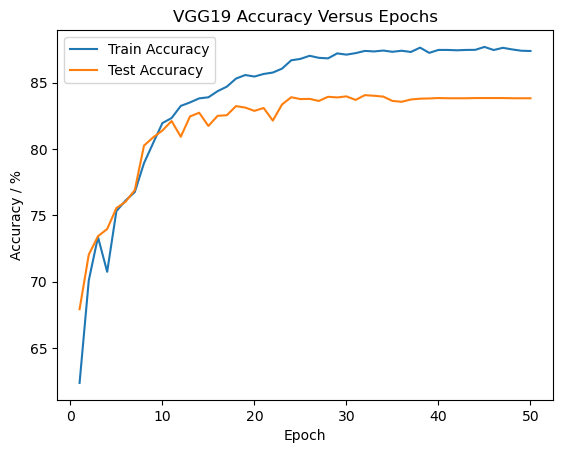

In [24]:
plt.plot(np.arange(1,len(train_accuracy)+1),train_accuracy,label='Train Accuracy')
plt.plot(np.arange(1,len(test_accuracy)+1),test_accuracy,label='Test Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy / %')
plt.title('VGG19 Accuracy Versus Epochs')
plt.show()